# Targeted vertical attack
This notebook investigates approaches to targeted vertical attack on German Credit data

In [2]:
import os
os.chdir("C:\\Users\\tsarcevic\\PycharmProjects\\fingerprinting-toolbox")
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pickle
import numpy as np
import pandas as pd
import collections
from pprint import pprint

from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

from scipy.stats import chi2
from matplotlib import pyplot

from datasets import GermanCredit

the goal: with feature selection achieve less utility loss

## 1. Impurity-based feature selection
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier.feature_importances_

In [4]:
with open('parameter_guidelines/evaluation/german_credit/rel_vertical_attack_utility_loss_gb_fpattr20.pickle', 'rb') as infile:
    utility_loss_20 = pickle.load(infile)

In [5]:
utility_loss_20

{1: [array([-0.1375    , -0.02739726, -0.05405405, -0.10828025, -0.05369128]),
  array([-0.11392405, -0.07236842, -0.09333333, -0.08441558, -0.02068966]),
  array([-0.09677419, -0.08974359, -0.07236842, -0.09090909, -0.07284768]),
  array([-0.04109589, -0.09803922, -0.10596026, -0.08441558, -0.0890411 ]),
  array([-0.07894737, -0.07894737, -0.07894737, -0.09090909, -0.09090909]),
  array([-0.04861111, -0.03896104, -0.11038961, -0.10666667, -0.0974026 ]),
  array([-0.09090909, -0.09150327, -0.10596026, -0.16666667, -0.09090909]),
  array([-0.07284768, -0.11949686, -0.09933775, -0.10191083, -0.08      ]),
  array([-0.08496732, -0.07843137, -0.08552632, -0.08974359, -0.0955414 ]),
  array([-0.07142857, -0.08280255, -0.03333333, -0.08108108, -0.05263158])],
 1.11: [array([-0.06711409, -0.11038961, -0.05405405, -0.09803922, -0.07236842]),
  array([-0.05921053, -0.08552632, -0.10322581, -0.10191083, -0.04054054]),
  array([-0.12578616, -0.0974026 , -0.09803922, -0.09032258, -0.06122449]),
  

In [5]:
np.mean([np.mean(ut) for ut in utility_loss_20[1]])

-0.08405137673083425

In [8]:
with open('parameter_guidelines/evaluation/german_credit/robustness_vertical_universal_c95_fpattr20_e100.pickle', 'rb') as infile:
    robustness_20 = pickle.load(infile)

In [6]:
fpattrs=[20,16,12,8,4]
robustness = dict()
for fpattr in fpattrs:
    with open('parameter_guidelines/evaluation/german_credit/robustness_vertical_universal_c95_fpattr{}_e100.pickle'.format(fpattr), 'rb') as infile:
        robustness[fpattr] = pickle.load(infile)

In [9]:
robustness_20

{1: 0.8,
 1.11: 0.75,
 1.25: 0.7,
 1.43: 0.7,
 1.67: 0.65,
 2: 0.75,
 2.5: 0.65,
 3: 0.6,
 4: 0.6,
 5: 0.5,
 6: 0.5,
 7: 0.45,
 8: 0.4,
 9: 0.35,
 10: 0.35,
 12: 0.25,
 15: 0.2,
 18: 0.1}

In [15]:
gamma=1
fp_dir = "parameter_guidelines/fingerprinted_data/german_credit/attr_subset_20/"
fingerprinted_data = pd.read_csv(fp_dir + "universal_g{}_x1_l8_u1_sk0.csv".format(gamma))
data = GermanCredit().preprocessed(fp_data=fingerprinted_data)

In [16]:
X_fp = data.drop('target', axis=1)
y_fp = data['target']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_fp, y_fp, test_size=0.2, random_state=9)

model = GradientBoostingClassifier()
model.fit(X_train, y_train)
acc = accuracy_score(y_test, model.predict(X_test))

In [18]:
acc

0.78

In [18]:
model = GradientBoostingClassifier(random_state=9)
original = cross_val_score(model, X_fp, y_fp)
original

array([0.79 , 0.755, 0.73 , 0.8  , 0.73 ])

In [19]:
model.feature_importances_

NotFittedError: This GradientBoostingClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

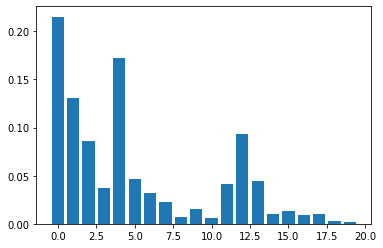

In [24]:
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

In [30]:
feature_importances = dict(zip(data.columns, model.feature_importances_))
feature_importances

{'checking_account': 0.21514958469895673,
 'duration': 0.13044392484665898,
 'credit_hist': 0.08577361202438204,
 'purpose': 0.037542360031586446,
 'credit_amount': 0.17261276703874145,
 'savings': 0.04680897088703411,
 'employment_since': 0.03161875938692153,
 'installment_rate': 0.022951027357519246,
 'sex_status': 0.006977414324585844,
 'debtors': 0.01549920743767321,
 'residence_since': 0.006314167794645683,
 'property': 0.04161068704700113,
 'age': 0.09356728372727559,
 'installment_other': 0.04487824182105095,
 'housing': 0.010520190596630376,
 'existing_credits': 0.013612419726994892,
 'job': 0.008691845710110693,
 'liable_people': 0.010437271782373785,
 'tel': 0.003110805448656495,
 'foreign': 0.0018794583112007593}

In [13]:
def drop_least_important(n, features):
    remaining = features
    for i in range(n):
        min_val = min(remaining.values())
        remaining = {k: v for k, v in remaining.items() if v != min_val}    
    return remaining

In [80]:
selected_f = drop_least_important(5, feature_importances)

In [81]:
len(selected_f)

15

In [84]:
removed = list(feature_importances.keys() - selected_f.keys())

In [106]:
X_fp = data.drop('target', axis=1)
X_fp = X_fp.drop(removed, axis=1)
print(len(X_fp.columns))
y_fp = data['target']

15


In [89]:
X_train, X_test, y_train, y_test = train_test_split(X_fp, y_fp, test_size=0.2, random_state=9)

model = GradientBoostingClassifier()
model.fit(X_train, y_train)
acc = accuracy_score(y_test, model.predict(X_test))

In [90]:
acc

0.775

In [107]:
model = GradientBoostingClassifier(random_state=9)
removed_25p = cross_val_score(model, X_fp, y_fp)
removed_25p

array([0.755, 0.755, 0.73 , 0.785, 0.75 ])

In [111]:
np.mean(removed_25p), np.mean(original)

(0.7550000000000001, 0.761)

In [117]:
results = dict()
for gamma in robustness_20:
    # remove robustness_20[gamma] percent of columns
    to_remove = int(20*robustness_20[gamma])
    selected_f = drop_least_important(to_remove, feature_importances)
    removed = list(feature_importances.keys() - selected_f.keys())
    X_fp = data.drop('target', axis=1)
    X_fp = X_fp.drop(removed, axis=1)
    print(len(X_fp.columns))
    y_fp = data['target']
    model = GradientBoostingClassifier(random_state=9)
    acc = cross_val_score(model, X_fp, y_fp)
    results[gamma] = acc

4
5
6
6
7
5
7
8
8
10
10
11
12
13
13
15
16
18


In [118]:
results

{1: array([0.76 , 0.735, 0.715, 0.73 , 0.72 ]),
 1.11: array([0.76 , 0.73 , 0.72 , 0.745, 0.74 ]),
 1.25: array([0.78 , 0.74 , 0.735, 0.765, 0.75 ]),
 1.43: array([0.78 , 0.74 , 0.735, 0.765, 0.75 ]),
 1.67: array([0.765, 0.745, 0.735, 0.77 , 0.755]),
 2: array([0.76 , 0.73 , 0.72 , 0.745, 0.74 ]),
 2.5: array([0.765, 0.745, 0.735, 0.77 , 0.755]),
 3: array([0.75 , 0.75 , 0.735, 0.755, 0.75 ]),
 4: array([0.75 , 0.75 , 0.735, 0.755, 0.75 ]),
 5: array([0.78 , 0.755, 0.76 , 0.775, 0.735]),
 6: array([0.78 , 0.755, 0.76 , 0.775, 0.735]),
 7: array([0.785, 0.755, 0.74 , 0.78 , 0.74 ]),
 8: array([0.785, 0.75 , 0.735, 0.775, 0.73 ]),
 9: array([0.775, 0.76 , 0.73 , 0.78 , 0.765]),
 10: array([0.775, 0.76 , 0.73 , 0.78 , 0.765]),
 12: array([0.755, 0.755, 0.73 , 0.785, 0.75 ]),
 15: array([0.78 , 0.765, 0.73 , 0.78 , 0.745]),
 18: array([0.78 , 0.78 , 0.75 , 0.775, 0.75 ])}

In [121]:
rel_loss = dict()
for gamma in results:
    loss = original - results[gamma] 
    rel_loss[gamma] = loss / original

In [125]:
with open('parameter_guidelines/evaluation/german_credit/rel_targeted_vertical_attack_utility_loss_gb_fpattr20_sk0.pkl', 'wb') as outfile:
    pickle.dump(rel_loss, outfile) 

In [123]:
for gamma in rel_loss:
    print(np.mean(rel_loss[gamma]))

0.037242265022387054
0.027967453265152174
0.008405840434901946
0.008405840434901946
0.008258942464375417
0.027967453265152174
0.008258942464375417
0.01585177052124615
0.01585177052124615
-0.000807395526270159
-0.000807395526270159
0.0007863707300156064
0.007470463082369781
-0.0021160760527183116
-0.0021160760527183116
0.007131307438876372
0.0007730499060078069
-0.008799775096260187


# Experiment

In [ ]:
feature_importances = {'checking_account': 0.21514958469895673,
 'duration': 0.13044392484665898,
 'credit_hist': 0.08577361202438204,
 'purpose': 0.037542360031586446,
 'credit_amount': 0.17261276703874145,
 'savings': 0.04680897088703411,
 'employment_since': 0.03161875938692153,
 'installment_rate': 0.022951027357519246,
 'sex_status': 0.006977414324585844,
 'debtors': 0.01549920743767321,
 'residence_since': 0.006314167794645683,
 'property': 0.04161068704700113,
 'age': 0.09356728372727559,
 'installment_other': 0.04487824182105095,
 'housing': 0.010520190596630376,
 'existing_credits': 0.013612419726994892,
 'job': 0.008691845710110693,
 'liable_people': 0.010437271782373785,
 'tel': 0.003110805448656495,
 'foreign': 0.0018794583112007593}

In [41]:
fpattr=4

In [42]:
with open('parameter_guidelines/evaluation/german_credit/robustness_vertical_universal_c95_fpattr{}_e100.pickle'.format(fpattr), 'rb') as infile:
    robustness = pickle.load(infile)

In [43]:
fp_dir = "parameter_guidelines/fingerprinted_data/german_credit/attr_subset_{}/".format(fpattr)
results = dict()
original = dict()
for gamma in robustness:
    fingerprinted_data = pd.read_csv(fp_dir + "universal_g{}_x1_l8_u1_sk0.csv".format(gamma))
    data = GermanCredit().preprocessed(fp_data=fingerprinted_data)
    
    #split
    X_fp = data.drop('target', axis=1)
    y_fp = data['target']
    # original accuracy
    model = GradientBoostingClassifier(random_state=9)
    original[gamma] = cross_val_score(model, X_fp, y_fp)
    
    # 
    to_remove = int(20*robustness[gamma])
    selected_f = drop_least_important(to_remove, feature_importances)
    removed = list(feature_importances.keys() - selected_f.keys())
    X_fp = data.drop('target', axis=1)
    X_fp = X_fp.drop(removed, axis=1)
    print(len(X_fp.columns))
    y_fp = data['target']
    model = GradientBoostingClassifier(random_state=9)
    acc = cross_val_score(model, X_fp, y_fp)
    results[gamma] = acc

11
11
11
12
12
13
12
13
14
14
14
15
16
16
15
18
19
18


In [44]:
rel_loss = dict()
for gamma in results:
    loss = original[gamma] - results[gamma] 
    rel_loss[gamma] = loss / original[gamma]

In [45]:
with open('parameter_guidelines/evaluation/german_credit/NEW_rel_targeted_vertical_attack_utility_loss_gb_fpattr{}_sk0.pkl'.format(fpattr), 'wb') as outfile:
    pickle.dump(rel_loss, outfile) 